# Tidal Calibration

This notebook is intended to demonstrate the tidal calibration process for Gladwin Tensor borehole Strainmeters (GTSM) following the methodology outlined in Hodgkinson et al. (2013) and applied in Hanagan et al. (In Prep). Note that tidal calibration requires a careful eye on the data for processing; so, when available, we suggest using the tidal calibrations provided in the metadata unless the user has a strong reason to belive the calibration requires an update. 

The workflow in this notebook can be summarized into three main parts: data aquisition, offset correction, and tidal time series analysis and modelling to acquire the final tidal calibration matrix. An additional benefit of the workflow implemented here is that we will also estimate the gauge response to barometric pressure. We correct the data for spurious offsets or pulses prior to tidal analysis because they are known to hinder accurate characterization of the tides and barometric pressure repsonse. 

The first portion of this notebook includes steps from the level 2 processing notebook. Then, new steps specific to the calibraiton process are completed. Sections in this notebook include:

* [Aquire station metadata and decimated timeseries](#get)
* [Offset correction](#offset)
* [Observed tidal analysis](#observed)
* [Predicted tides](#predicted)
* [Orientation matrix](#orientation)
* [References](#references)






## Aquire station metadata and decimated timeseries <a id="get"></a>

In [1]:
# Import relevant modules from the earscopestraintools package
from earthscopestraintools.mseed_tools import ts_from_mseed
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import plot_timeseries_comparison

import numpy as np
import pandas as pd

# Allow logged output to be printed in the notebook as code cells are run
import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

IV TSM6 Loading T0 LS* from 2022-10-21T00:00:00.000000 to 2023-03-09T23:59:59.000000 from Earthscope DMC miniseed
    Trace 1. 2022-10-21T00:00:00.000000Z:2023-03-09T23:59:59.000000Z mapping LS1 to CH0
    Trace 2. 2022-10-21T00:00:00.000000Z:2023-03-09T23:59:59.000000Z mapping LS2 to CH1
    Trace 3. 2022-10-21T00:00:00.000000Z:2023-03-09T23:59:59.000000Z mapping LS3 to CH2
    Trace 4. 2022-10-21T00:00:00.000000Z:2023-03-09T23:59:59.000000Z mapping LS4 to CH3
    Found 0 epochs with nans, 29.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
  Converting 999999 gap fill values to nan
    Found 29 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM6.T0.LS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2022-10-21 00:00:00 - 2023-03-09 23:59:59        | Period:           1.0s
    | Series:         raw| Units:        counts| Level:          0| Gaps:             0.0% 
    | Epochs:    

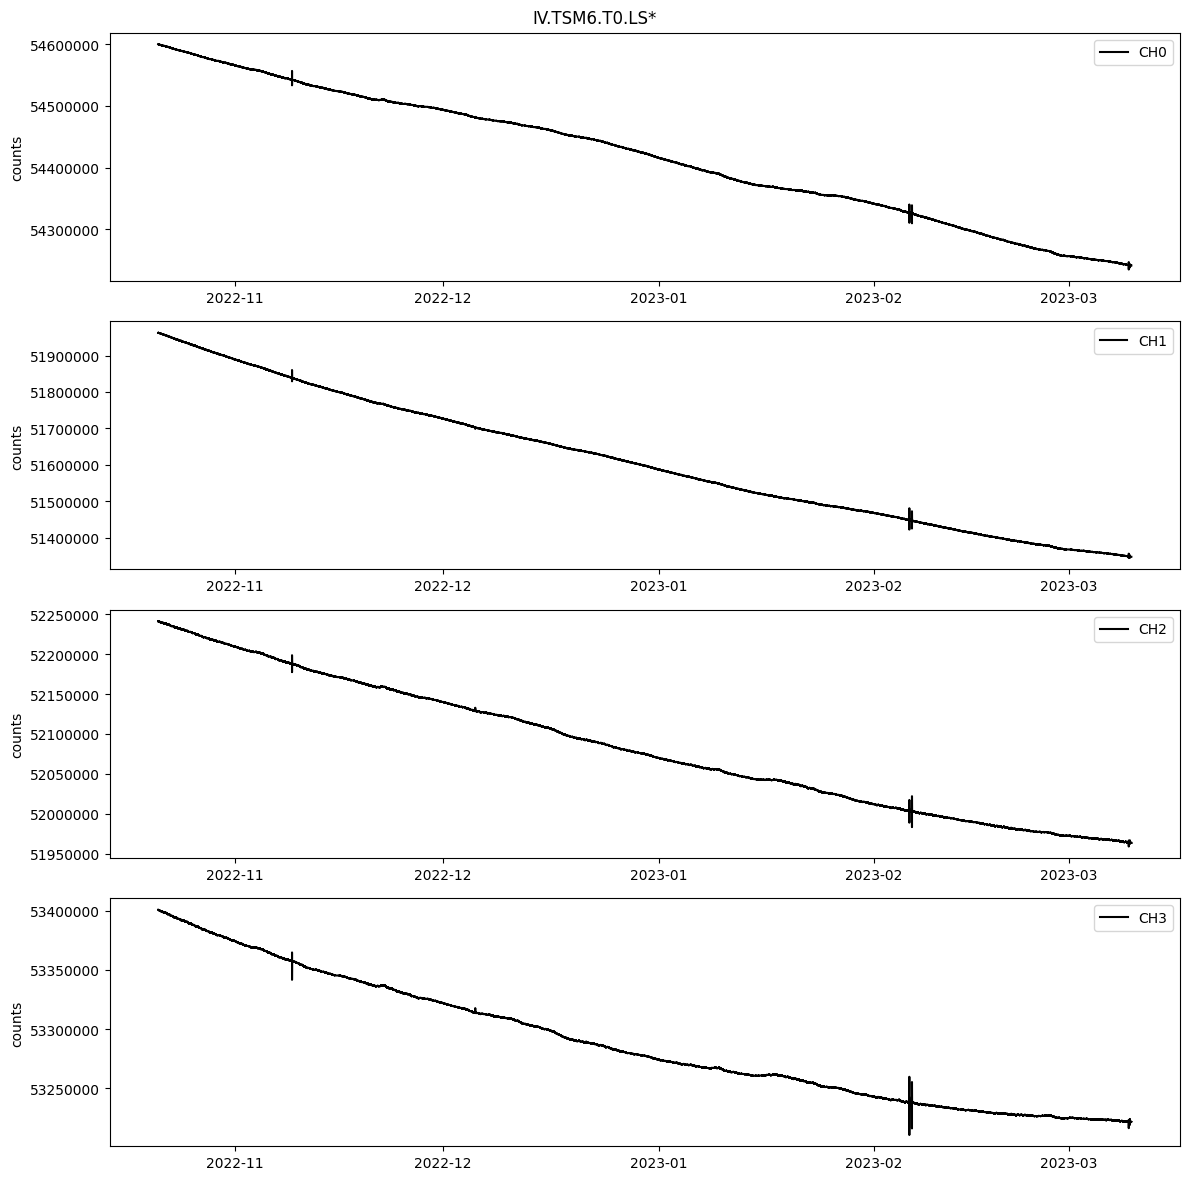

In [2]:
# Linearize 1 hz strain from the IRIS/EarthScope DMC, filter/decimate to 5 min
# and acquire 30 min pressure data

# Metadata
network = 'IV'
station = 'TSM6' 
meta = GtsmMetadata(network,station)

# Provide the start and end times for calibration
start = "2022-10-21T00:00:00.000000"
end = "2023-03-09T23:59:59.000000"

# load data
strain_raw = ts_from_mseed(network=network, station=station, location='T0', channel='LS*', start=start, end=end)
# Print stats and plot the data
strain_raw.stats()
strain_raw.plot(type='line')

In [4]:
# Filter to 5 min, then to hourly in a 2 step filter and convert to nstrain
# Save the hourly data in a separate Timeseries with an index in datetime seconds 

# filter and decimate to 5 min
decimated_counts = strain_raw.decimate_1s_to_300s(method='linear',limit=3600)
filt_cutoff_s = 2*60*60 # 2 hr cutoff period 
# Applies a lowpass butterworth filter via the scipy butterworth filter function
filtered_hr_counts = decimated_counts.butterworth_filter(filter_type='lowpass',filter_order=5,
                                                          filter_cutoff_s=filt_cutoff_s)
# Decimates the data to hourly by taking the first minute/second of each hour
decimated_hr_counts = filtered_hr_counts.decimate_to_hourly()
# Linearize to microstrain
decimated_hr_strain = decimated_hr_counts.linearize(reference_strains=meta.reference_strains,gap=meta.gap)

Decimating to 300s
Interpolating data using method=linear and limit=3600
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying Butterworth Filter
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Decimating to hourly
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Converting raw counts to microstrain
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


## Offset correction<a class="anchor" id="offset"></a>

We will correct for offsets via a simple first differencing method. To enable better estimates of the offsets, we first correct the data for a "first estimate" of tides, trend, and pressure. For this time series, we use Baytap08 (more information on the program is described in the next section) to retreive an initial estimate of the tides and pressure response for the purpose of preliminary correction. 

In [5]:
# Acquire atmospheric pressure data and filter to hourly

# Pressure data from miniseed
atmp_raw = ts_from_mseed(network=network, station=station, location='*', channel='RDO',
                        start=start, end=end, period=60*30, scale_factor=0.001, units='hpa')
# Interpolate, filter and decimate to hourly
atmp_interp = atmp_raw.interpolate()
atmp_filt = atmp_interp.butterworth_filter(filter_type='lowpass',filter_order=5,
                                        filter_cutoff_s=filt_cutoff_s)
atmp = atmp_filt.decimate_to_hourly()

# Run baytap preliminarily to retrieve the pressure response and tidal amplitudes and phases for the full metadata suite
prelim_baytap_results = decimated_hr_strain.baytap_analysis(atmp,latitude=meta.latitude,longitude=meta.longitude,elevation=meta.elevation,dmin=0.001)


IV TSM6 Loading * RDO from 2022-10-21T00:00:00.000000 to 2023-03-09T23:59:59.000000 from Earthscope DMC miniseed
    Trace 1. 2022-10-21T00:00:00.000000Z:2023-03-09T23:30:00.000000Z mapping RDO to atmp
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
  Converting 999999 gap fill values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Interpolating data using method=linear and limit=2
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying Butterworth Filter
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Decimating to hourly
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Please note, this method expects continuous data in microstrain and pressure in hPa.


c51acb8ae945f6eddbe81bb0438d1a3bbd3ce97ede1b175ec5ea07384cdf6c4e
Docker container started.
Atmospheric pressure responses in microstrain/hPa and tidal parameters in degrees/nanostrain 
baytap
Docker processes finished. Container removed.


Calculating pressure correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating linear trend correction
    Trend Start: 2022-10-21 00:00:00
    Trend End: 2023-03-09 23:00:00
  Median trend calculated with points 24.0 hr apart.
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating tide correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Calculating offsets using cutoff percentile of 0.75 and limit multiplier of 10.
Using offset limits of [0.052, 0.077914, 0.035516, 0.021359]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, a

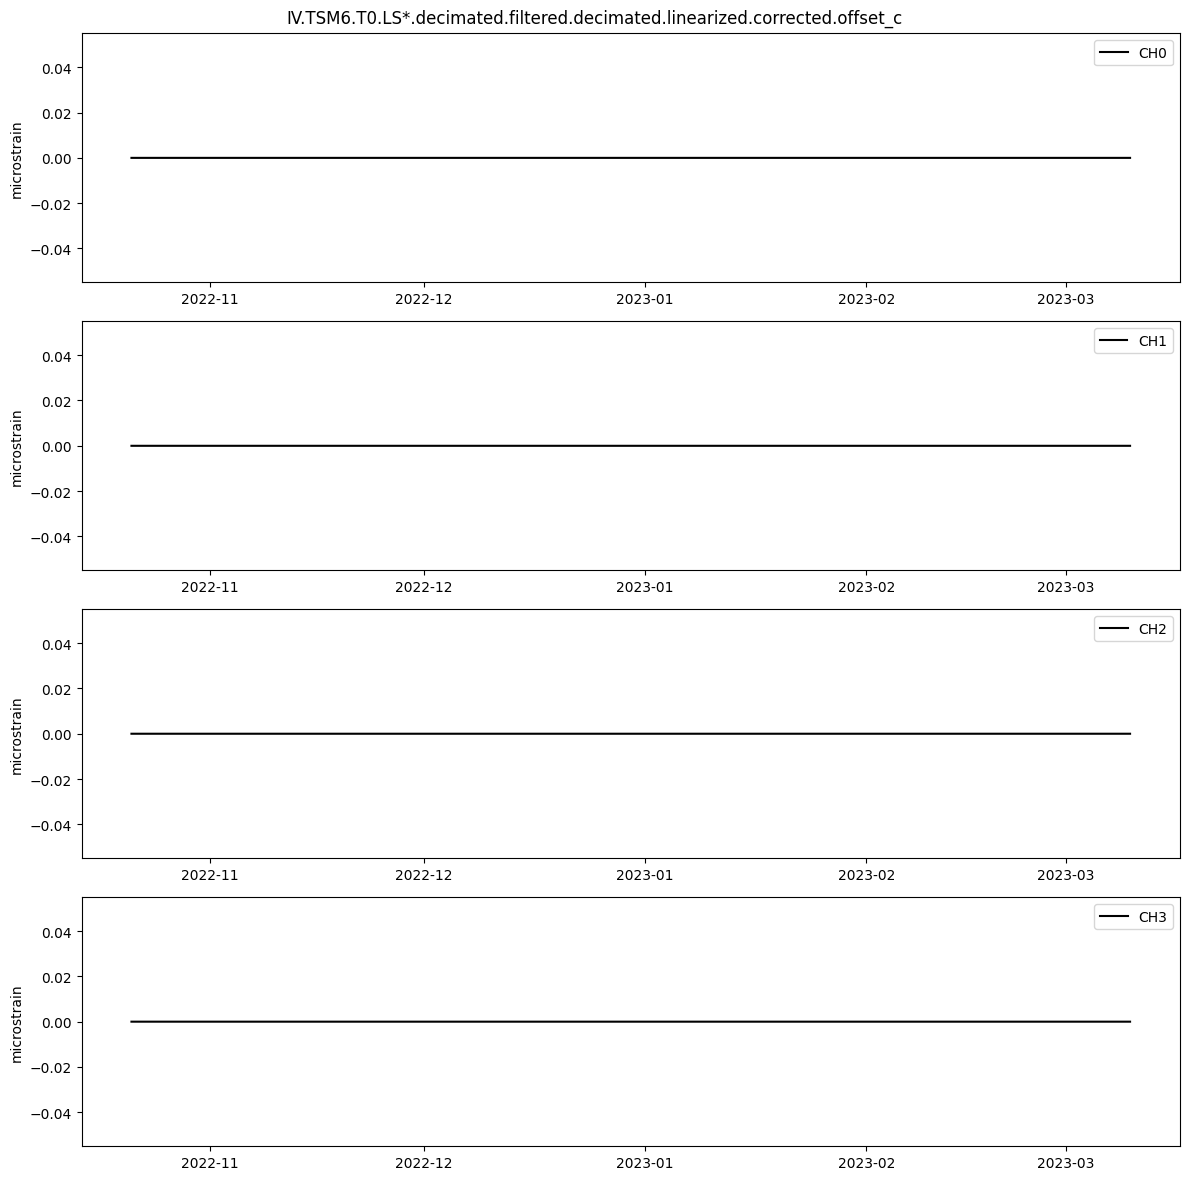

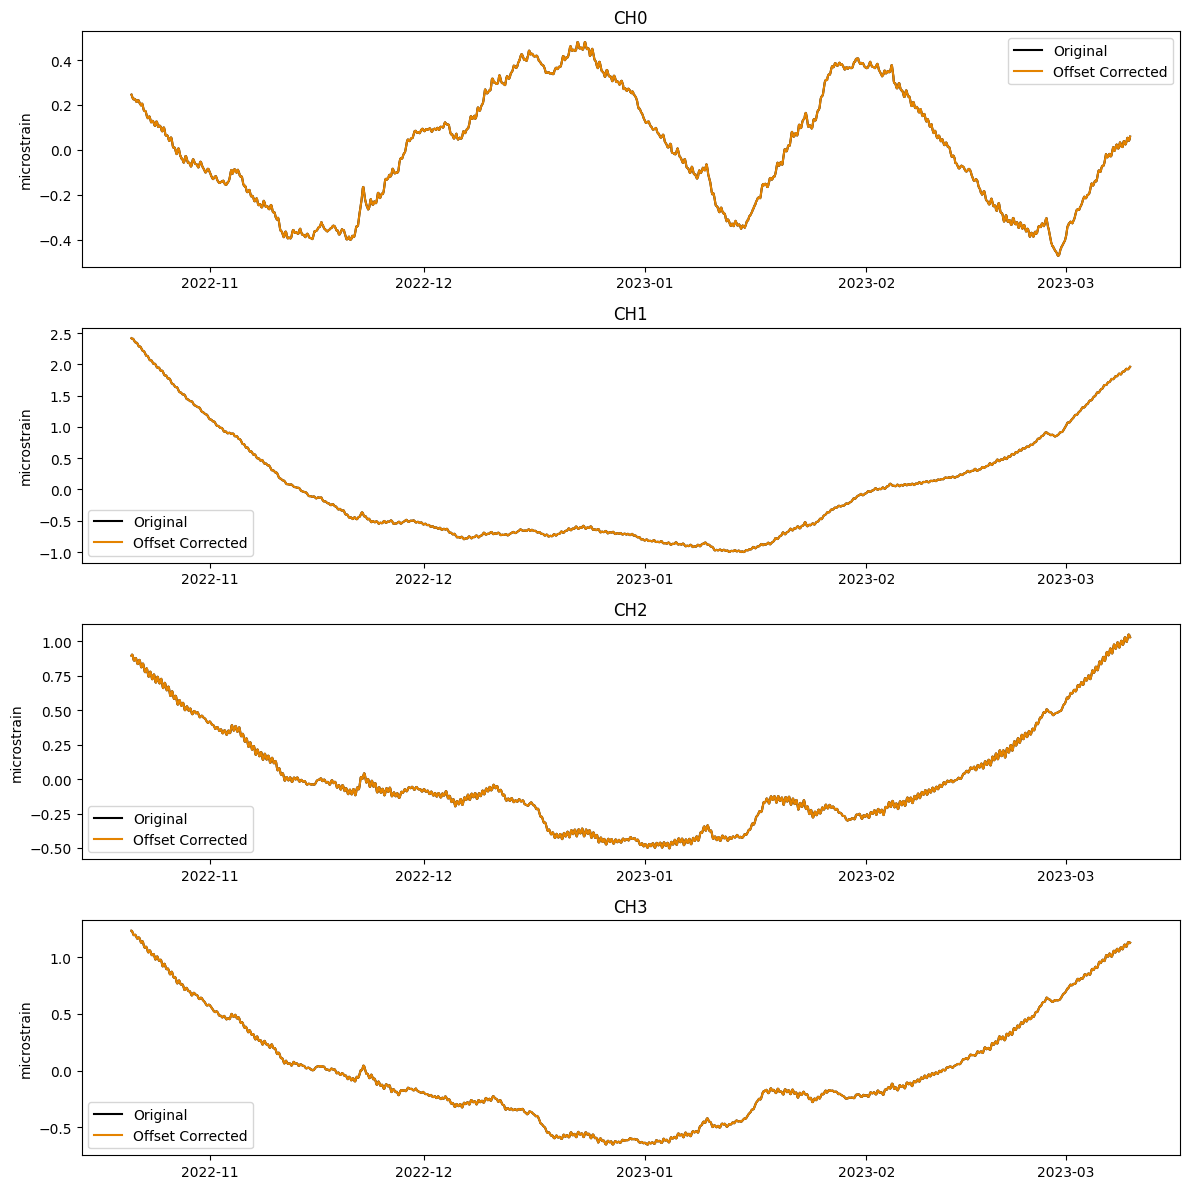

In [6]:
# Corrections prior to offset correcteion
atmp_c = atmp.calculate_pressure_correction(response_coefficients=prelim_baytap_results['atmp_response'])
trend_c = decimated_hr_strain.linear_trend_correction(method='median')
tide_c = decimated_hr_strain.calculate_tide_correction(tidal_parameters=prelim_baytap_results['tidal_params'],longitude=meta.longitude)
pre_offset_corrected = decimated_hr_strain.apply_corrections([trend_c,tide_c,atmp_c])
offset_c = pre_offset_corrected.calculate_offsets(limit_multiplier=10)
offset_corrected = decimated_hr_strain.apply_corrections([offset_c])
offset_c.plot()
plot_timeseries_comparison([decimated_hr_strain,offset_corrected],names=['Original','Offset Corrected'],zero=True,detrend='linear')

## Observed tidal analysis <a class="anchor" id="#observed"></a>

The tidal constituents (amplitudes and phases of daily and bi-daily tides) will be determined from the observed strain timeseries in a program called BAYTAP08 (Tamura 1991; Tamura and Agnew 2008). The original BAYTAP-G program was rewritten by Duncan Agnew as BAYTAP08: http://igppweb.ucsd.edu/~agnew/Baytap/baytap.html. The primary function of BAYTAP08 is to isolate distinct tidal amplitudes and phases from data streams contaminated by other signals through assuming a smoothly varying drift, which is empirically inferred by minimizing Akaike's Bayesian Information Criterion (ABIC).
 
To summarize, the program assumes a strain signal ($y_i$) composed of the following components: 

>$$y_i = t_i + d_i + c_i + s_i$$
- $t_i$: tidal signal
- $d_i$: long term trend (instrument drift)
- $c_i$: response to other effects (e.g., barometric pressure)
- $s_i$: data offsets


The tidal signal is composed of the tidal amplitudes and phases we seek ($A_m$ and $B_m$), and the known theoretical tidal group values ($C_{mi}$ and $S_{mi}$) that are the sum of the constituents with similar frequencies:
>$$t_i =\sum_{m=1}^{M} (A_m C_{mi}+B_m S_{mi})$$

The barometric response is considered linear with the barometric pressure change. Where, $b_i$ is the barometric response coefficient:
>$$c_i=b_i y_i$$

The residual time series is left once these signals are removed: 
>$$ r_i = y_i - (t_i + d_i + c_i + s_i)$$

BAYTAP solves for the model parameters by minimizing S:
>$$S = \sum_{i=1}^{N}r_i^2+ D^2 \sum_{i=1}^{n} (d_i - 2d_{i-1} + d_{i-2})^2 + W^2 \sum_{m=2}^{M}(A_m - A_{m-1})^2+(B_m-B_{m-1})^2 $$
- D (drift) is an input smoothness parameter, where a very large D provides a linear drift with time. 
- W is an input parameter that controls how much the tidal admittance can vary over frequency bands. We allow W to assume the default value of 1. 

Typically, the strainmeters have already been analyzed with BAYTAP, and those outputs are what we used to perform the preliminary corrections prior to detecting offsets and pulses in the previous step. Here, the goal is to reanalyze the tidal amplitudes and phases to perform tidal calibration. More specifically, we are interested in the M2 and O1 tidal constituent amplitudes and phases per gauge. 



In [7]:
# Run baytap to retrieve the pressure response and tidal amplitudes and phases for the full metadata suite
baytap_results= offset_corrected.baytap_analysis(atmp,latitude=meta.latitude,longitude=meta.longitude,elevation=meta.elevation,dmin=0.001)


Please note, this method expects continuous data in microstrain and pressure in hPa.


3c945f2816fa092653e99f788c39f984da5f47fc8c57b8fd462141c7274e34dc
Docker container started.
Atmospheric pressure responses in microstrain/hPa and tidal parameters in degrees/nanostrain 
baytap
Docker processes finished. Container removed.


In [8]:
# Print the results for the M2 and O1 tidal constituents
for ch in offset_corrected.columns:
    print(f'{ch}:')
    print('M2 amp (nstrain) and phase (degree):',
          baytap_results['tidal_params'][(ch,'M2','amp')],baytap_results['tidal_params'][(ch,'M2','phz')])
    print('O1 amp (nstrain) and phase (degree):',
          baytap_results['tidal_params'][(ch,'O1','amp')],baytap_results['tidal_params'][(ch,'O1','phz')])

CH0:
M2 amp (nstrain) and phase (degree): 5.952 -46.456
O1 amp (nstrain) and phase (degree): 3.838 132.751
CH1:
M2 amp (nstrain) and phase (degree): 8.581 63.765
O1 amp (nstrain) and phase (degree): 4.589 -116.435
CH2:
M2 amp (nstrain) and phase (degree): 13.151 -165.769
O1 amp (nstrain) and phase (degree): 2.582 10.172
CH3:
M2 amp (nstrain) and phase (degree): 8.040 -120.468
O1 amp (nstrain) and phase (degree): 3.682 60.212


## Predicted tides <a class="anchor" id="predicted"></a>


In this section, we will gather the predicted M2 and O1 tidal amplitudes and phases for the areal, differential shear, and engineering shear strains for the station using SPOTL (Some Programs for Ocean Tide Loading; Agnew, 2013). SPOTL, like BAYTAP, will be run from a Docker container. 

In [9]:
from earthscopestraintools.processing import spotl_predict_tides

# Parameters for the tidal model
latitude= meta.latitude
longitude = meta.longitude
elevation = meta.elevation
# Regional ocean load model, global ocean load model, and Green's functions to decribe the elastic Earth
# available from the SPOTL package
reg_oc = 'osu.mediterranean.2011'
glob_oc= 'osu.tpxo72.2010' # change to osu.tpxo72atlas.2011 ?
greenf = 'green.contap.std'

pred_tides = spotl_predict_tides(latitude,longitude,elevation,glob_oc,reg_oc,greenf)
pred_tides

Docker started
spotl
Docker container stopped and removed.


{'M2': {'areal': (15.260654206772385+1.559118536665793j),
  'differential': (-10.46438760598575-3.393253671866749j),
  'engineering': (0.9177684867587321-5.360603600781594j)},
 'O1': {'areal': (11.46017566155345+0.08470101319819293j),
  'differential': (2.8783089246691294+0.03687517960914067j),
  'engineering': (-0.24828220829683426+3.638939777606006j)}}

## Orientation matrix <a class="anchor" id="orientation"></a>

The orientation matrix is determined through simple least squares with the M2 and O1 tidal results in the code cells below, as described in Hodgkinson et al., (2013). Essentially, the orientation matrix that transforms the observed tidal to match the predicted tides is determined.

The forward problem, with gauge strains $e_i$, regional strains $E_j$, and the coupling matrix $A_{ij}$ has the form:

>$$ e_{i} = A_{ij} E_{j}$$ <br>
>$$\begin{pmatrix} e_{0} \\ e_{1} \\ e_{2} \\ e_{3} \end{pmatrix} = \begin{pmatrix} a_{11} & a_{12} & a_{13} & a_{14} \\ a_{21} & a_{22} & a_{23} & a_{24} \\ a_{31} & a_{32} & a_{33} & a_{34} \end{pmatrix} \begin{pmatrix} e_{EE} + e_{NN} \\ e_{EE} - e_{NN} \\ 2e_{EN} \end{pmatrix} = \begin{pmatrix} E_A \\ E_D \\ E_S \end{pmatrix}$$


The orientation matrix is the Moore-Penrose pseudoinverse of the coupling matrix, and is applied to the gauge strains as follows to attain the regional areal, differential, and engineering shear strains:


>$$A^{-1}_{ji} e_{i} = E_{j}$$ <br>
>$$\begin{pmatrix} a_{11} & a_{12} & a_{13} & a_{14} \\ a_{21} & a_{22} & a_{23} & a_{24} \\ a_{31} & a_{32} & a_{33} & a_{34} \end{pmatrix}^{-1} \begin{pmatrix} e_{0} \\ e_{1} \\ e_{2} \\ e_{3} \end{pmatrix} = \begin{pmatrix} e_{EE} + e_{NN} \\ e_{EE} - e_{NN} \\ 2e_{EN} \end{pmatrix} = \begin{pmatrix} E_A \\ E_D \\ E_S \end{pmatrix}$$



In [10]:
# Compute the observed real and imaginary components of the tidal amplitudes and phases, 
# and place in a 4x4 matrix
def make_complex(ampstr, phzstr):
    amp, phz = float(ampstr), float(phzstr)
    return complex(amp*np.cos(phz*np.pi/180),amp*np.sin(phz*np.pi/180))
    
obs_tide_matrix = np.zeros([4,4])
for i,ch in enumerate(offset_corrected.columns):
    m2 = make_complex(baytap_results['tidal_params'][(ch,'M2','amp')], baytap_results['tidal_params'][(ch,'M2','phz')])
    o1 = make_complex(baytap_results['tidal_params'][(ch,'O1','amp')], baytap_results['tidal_params'][(ch,'O1','phz')])
    obs_tide_matrix[i,:] = np.real(m2), np.imag(m2),  np.real(o1), np.imag(o1)
print('Observed tidal matrix:')
obs_tide_matrix

Observed tidal matrix:


array([[  4.10040077,  -4.31428065,  -2.60528645,   2.81828432],
       [  3.7932643 ,   7.69705833,  -2.04294137,  -4.10917407],
       [-12.74742848,  -3.23293493,   2.5414162 ,   0.45599088],
       [ -4.07673876,  -6.92977641,   1.8291889 ,   3.19549557]])

In [11]:
# For the predicted tide matrix, 3x4
pred_tide_matrix = np.array([[np.real(pred_tides['M2']['areal']),np.imag(pred_tides['M2']['areal']),
                              np.real(pred_tides['O1']['areal']),np.imag(pred_tides['O1']['areal'])],
                             [np.real(pred_tides['M2']['differential']),np.imag(pred_tides['M2']['differential']),
                              np.real(pred_tides['O1']['differential']),np.imag(pred_tides['O1']['differential'])],
                             [np.real(pred_tides['M2']['engineering']),np.imag(pred_tides['M2']['engineering']),
                              np.real(pred_tides['O1']['engineering']),np.imag(pred_tides['O1']['engineering'])]])
print('Predicted tidal matrix:')
pred_tide_matrix

Predicted tidal matrix:


array([[ 15.26065421,   1.55911854,  11.46017566,   0.08470101],
       [-10.46438761,  -3.39325367,   2.87830892,   0.03687518],
       [  0.91776849,  -5.3606036 ,  -0.24828221,   3.63893978]])

In [12]:
# Calculate the orentation matrix from the coupling matrix
coupling_mat = np.linalg.lstsq(pred_tide_matrix.T,obs_tide_matrix.T,rcond=-1)[0].T
res2 = np.linalg.lstsq(pred_tide_matrix.T,obs_tide_matrix.T,rcond=-1)[1]
orient_mat = np.linalg.pinv(coupling_mat)
print('Coupling Matrix:\n',coupling_mat)
print('****************************')
print('Tidal Orientation Matrix:\n',orient_mat)
print('****************************')
print('Residuals (obs-modelled)')
print(obs_tide_matrix - np.dot(coupling_mat,pred_tide_matrix))
# Sum of squared residuals, 
# divided by number of data (4 per gauge) 
print('RMSE, per gauge:\n',np.sqrt(res2/4))
print('RMSE:\n',np.sqrt(sum(res2)/16))


Coupling Matrix:
 [[-0.09096755 -0.42860173  0.96793659]
 [-0.0633136  -0.55150997 -1.11033455]
 [-0.06478505  1.10996678 -0.04721664]
 [ 0.04619594  0.5426821   0.93494383]]
****************************
Tidal Orientation Matrix:
 [[-5.12932898 -2.72819362 -4.2436418   1.8560335 ]
 [-0.28187131 -0.13681923  0.64494738  0.1619035 ]
 [ 0.42612767 -0.30968062 -0.11394592  0.25488826]]
****************************
Residuals (obs-modelled)
[[ 0.11522879 -0.43808147 -0.08881272 -0.68046883]
 [ 0.00728722 -0.02770486 -0.00561664 -0.04303377]
 [-0.10030978  0.38136178  0.07731388  0.59236653]
 [ 0.03905479 -0.14848008 -0.03010152 -0.23063306]]
RMSE, per gauge:
 [0.41113215 0.02600055 0.35790166 0.13934608]
RMSE:
 0.28160992700842585


## References <a class="anchor" id="references"></a>

Agnew, D. C. (2012). SPOTL: Some Programs for Ocean-Tide Loading, SIO Technical Report, Scripps Institution of Oceanography. From https://igppweb.ucsd.edu/~agnew/Spotl/spotlmain.html

Hodgkinson, K., J. Langbein, B. Henderson, D. Mencin, and A. Borsa (2013), Tidal calibration of plate boundary observatory borehole strainmeters, J. Geophys. Res. Solid Earth, 118, 447–458, doi:10.1029/2012JB009651.

Tamura, Y., & Agnew, D. C. (2008). Baytap08 User's Manual. UC San Diego: Library – Scripps Digital Collection. From https://escholarship.org/uc/item/4c27740c